
<div align="center"><img width="275" height="50" src="http://zillow.mediaroom.com/image/Zillow_Wordmark_Blue_RGB.jpg" /> </div> 

<div align="center"> <h1>Cluster Project</h1> 
  <h6> by John Grinstead & David Berchelmann -- April 7, 2021 </h6> </div>
  
  ------------------------------------------------

<div align="center"><img width="800" height="50" src="https://www.zillowstatic.com/s3/homepage/static/Buy_a_home.png" /> </div>



-------

<h1> Welcome! </h1>

The following jupyter notebook will take you through my regression project focusing on Zillow. The dataset comes from a SQL database and can also be accessed via Kaggle.com. 

All of the files and notebooks for this project can be accessed via the github repostiory located at --> https://github.com/davidb-and-john/clustering-project

For ease of reading, many of the large coding sections have been minimzed to allow for a better scrolling experience. If you would like to enlarge a cell to see the data inside, please click on the three dots (<b>...</b>) for the specific cell. To reduce the cell, click the blue box to the left of the selected cell.

----

<h1> Executive Summary </h1>

------

<h4><b>The Problem</b></h4>

- What is driving the errors in the Zestimates?

<h4><b>The Goal</b></h4>

- Use clustering to identify what groups of features are the strongest drivers of log error.

<h4><b>The Process</b></h4>

  * Acquire the Data
  * Prepare 
  * Explore 
  * Model
  * Create Recommendations Based On Findings 
  
<h4><b>The Findings</b></h4>

    
    


-------


<h3><u>Environment Setup</u></h3>

In [1]:
# packages for data analysis & mapping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as dates
import seaborn as sns
import plotly.express as px
from datetime import date 


# Statistical Tests
import scipy.stats as stats
from math import sqrt
from scipy.stats import norm


# modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE 
import sklearn.preprocessing
from sklearn.cluster import KMeans

pd.options.display.float_format = '{:20,.2f}'.format


# address warnings
import warnings
warnings.filterwarnings("ignore")

# acquire, prep, train, & explore functions
from wrangle import get_connection, new_zillow_data, get_zillow_data, clean_zillow, split, seperate_y, scale_data, split_seperate_scale, missing_zero_values_table
import explore


<h4> Data Validation </h4>

 - Before the data was brought in through the acquire file, we investigated the set in SQL. Below are a few of our findings:
     - Some properties were labeled as 'single family residential' but had a unit count of more than 1
     - There were a number of properties that lacked location info (zip, lat, long, fips), these will be dropped in prep
     - Bedrooms and Bathrooms both have rows that have a value of 0. These were filled filled with the median count for each feature.
     - There were entries that had multiple transaction dates. To account for this, we filtered for the latest max date. We also did this for log error.

---
<h3><u>Acquire the Data</u></h3>

----

In [2]:
df = pd.read_csv("zillowcluster_df.csv")
print(f'Our original dataframe is coming in with {df.shape[0]} rows and {df.shape[1]} columns.')

Our original dataframe is coming in with 77413 rows and 68 columns.


In [4]:
df.describe()

,Unnamed: 0,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,"77,413.00",222.00,50.00,"49,439.00",15.00,206.00,"24,953.00","77,413.00","77,413.00",50.00,...,"17,560.00",172.00,"77,268.00","77,379.00","77,380.00","77,378.00","77,375.00","2,886.00","77,136.00","77,413.00"
mean,"38,706.00",6.04,7.00,3.92,3.93,7.39,1.81,"13,006,697.32","1,495,761.15",679.72,...,1.43,1.00,"189,315.98","490,137.46","2,016.00","301,096.94","5,995.57",14.09,"60,496,735,236,339.62",0.02
std,"22,347.35",0.56,0.00,3.59,0.26,2.73,2.97,"3,480,712.14","861,270.67",689.70,...,0.54,0.00,"230,088.56","653,447.67",0.00,"492,599.03","7,622.89",2.19,"1,535,251,869,244.56",0.17
min,0.00,4.00,7.00,1.00,3.00,2.00,1.00,"10,711,855.00",349.00,38.00,...,1.00,1.00,44.00,"1,000.00","2,016.00",161.00,19.92,3.00,"60,371,011,101,000.00",-4.66
25%,"19,353.00",6.00,7.00,2.00,4.00,7.00,1.00,"11,538,336.00","752,413.00",273.00,...,1.00,1.00,"84,265.00","207,000.00","2,016.00","85,504.00","2,715.59",14.00,"60,373,109,005,001.75",-0.02
50%,"38,706.00",6.00,7.00,2.00,4.00,7.00,1.00,"12,530,673.00","1,498,471.00",515.00,...,1.00,1.00,"136,499.50","358,976.00","2,016.00","203,383.50","4,450.72",15.00,"60,376,032,003,008.00",0.01
75%,"58,059.00",6.00,7.00,7.00,4.00,7.00,1.00,"14,211,486.00","2,241,718.00",796.50,...,2.00,1.00,"218,787.50","569,003.00","2,016.00","366,802.25","6,927.80",15.00,"60,590,423,251,008.00",0.04
max,"77,412.00",13.00,7.00,24.00,4.00,21.00,13.00,"167,689,317.00","2,985,182.00","3,560.00",...,6.00,1.00,"11,421,790.00","49,061,236.00","2,016.00","48,952,198.00","586,639.30",99.00,"483,030,105,084,015.00",5.26


In [6]:
missing_zero_values_table(df)

Your selected dataframe has 68 columns and 77413 Rows.
There are 63 columns that have NULL values.


,Zero Values,null_count,% of Total Values,Total Zeroes + Null Values,% Total Zero + Null Values,Data Type
buildingclasstypeid,0,77398,100.00,77398,100.00,float64
buildingclassdesc,0,77398,100.00,77398,100.00,object
finishedsquarefeet13,0,77372,99.90,77372,99.90,float64
storytypeid,0,77363,99.90,77363,99.90,float64
storydesc,0,77363,99.90,77363,99.90,object
basementsqft,0,77363,99.90,77363,99.90,float64
yardbuildingsqft26,0,77343,99.90,77343,99.90,float64
fireplaceflag,0,77241,99.80,77241,99.80,float64
architecturalstyletypeid,0,77207,99.70,77207,99.70,float64
architecturalstyledesc,0,77207,99.70,77207,99.70,object


-----
<h3><u> Initial Thoughts</u> </h3>

- This data set is extrememly messy and is littered with nulls and zero values. With so many nulls, each category will be reviewed to determine if there is a way to fill those nulls with values or if they will need to be deleted all togther.

- We will look at the missing values table again in the prep stage to see how our dataset was cleaned up.

- There is redundancy in columns (like those dealing with square footage) that will be dealt with.

----

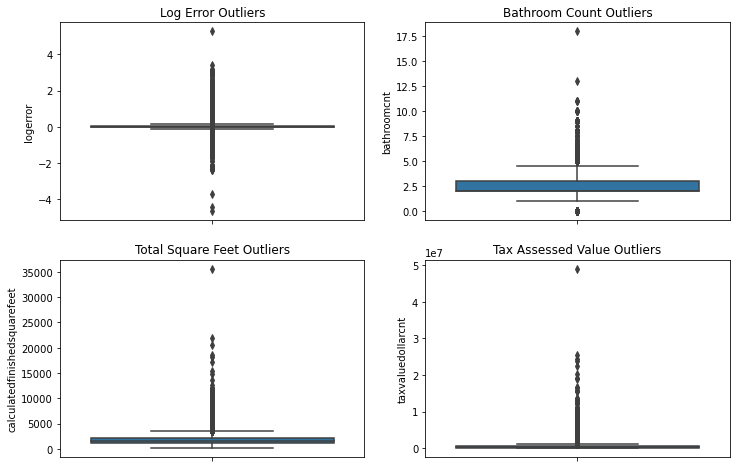

In [7]:
# visualize outliers using boxplots:

plt.figure(figsize = (12,8))
plt.subplot(221)
sns.boxplot(y = df.logerror)
plt.title('Log Error Outliers')

plt.subplot(222)
sns.boxplot(y = df.bathroomcnt)
plt.title('Bathroom Count Outliers')


plt.subplot(223)
sns.boxplot(y = df.calculatedfinishedsquarefeet)
plt.title('Total Square Feet Outliers')


plt.subplot(224)
sns.boxplot(y = df.taxvaluedollarcnt)
plt.title('Tax Assessed Value Outliers')

plt.show()

In [8]:
# Calculate q1, q3 and iqr for log error

q1 = df.logerror.quantile(0.25)
q3 = df.logerror.quantile(0.75)
iqr = q3 - q1
k = 3.0

# calculate upper and lower ranges
upper_bound_logerror =  q3 + k * iqr
lower_bound_logerror =  q1 - k * iqr

print(f'the upperbound log error is {upper_bound_logerror}')
print(f'the lowerbound log error is {lower_bound_logerror}')

the upperbound log error is 0.229883439404
the lowerbound log error is -0.2146613836911


<h3><u>Boxplot Takeaways</u></h3>

- There are some major outliers that will need to be dealt with in prep. 
- Bathroom outliers may be dealt with by taking care of finished square feet first. 
- There are outliers within Log Error but these will be kept in since it is our target variable. 
    - In the future, a separte model could be created to evaluate the outliers to see what is behind those larger differences between zestimate and actual price

----

<h3>Clean/Prep the Data</h3>

----

In [9]:
df = clean_zillow(df)

------

<h5><i>Before we get into what prep was done to the data, let's take a look at our missing values table. If you go back up to cell 22, you will see that this data set was littered with null values and zeros. Let's take another peak.</i></h5>

-----

In [10]:
missing_zero_values_table(df)

Your selected dataframe has 29 columns and 60655 Rows.
There are 0 columns that have NULL values.


,Zero Values,null_count,% of Total Values,Total Zeroes + Null Values,% Total Zero + Null Values,Data Type
heatingorsystemtypeid,0,0,0.00,0,0.00,float64
heatingorsystemdesc,0,0,0.00,0,0.00,object
orange_county,41916,0,0.00,41916,69.10,uint8
la_county,24266,0,0.00,24266,40.00,uint8
bath_amenity_house,46921,0,0.00,46921,77.40,int64
has_amenities,44695,0,0.00,44695,73.70,int64
bath_bed_ratio,0,0,0.00,0,0.00,float64
sqft_bin,2443,0,0.00,2443,4.00,float64
acres_bin,7551,0,0.00,7551,12.40,float64
acres,0,0,0.00,0,0.00,float64


---

<h5><i>As you can see, we went from 68 columns and 77,413 rows down to 30 columns and 60,655 rows</i></h5>

---

<h3>Prep Work Done To Data</h3>

----

    
- Create new column (age_of_home)
    today = pd.to_datetime('today')
    df['age_of_home'] = today.year - df['yearbuilt']

- Created an age bin to allow for better exploring
    
- Removed nulls from longitude which also cleaned up latitude as well               
- Focused the dataset on properties that identified only as single unit though a property id

- We also dropped any rows that featured a unit count greater than 1

- Pool count was examined and it was found that null values should be replaced with 0. This turned the column into a binary where 1 = Has Pool and 0 = No Pool

- Created a new feature called bathrooms per sqft

- Created a tax rate column

- To handle all of the null values in the lot size square footage, those columns were filled with a median value for the lot size

- A feature called 'acres' was created by dividing lot size square footage by 43,560.

- An acres bin column was also formed to assist with better exploring

- A square footage bin was created

- datatypes were changed to float64 for the following features:
    - sqft_bin
    - acres_bin
    - age_bin
    
- Nulls were removed from taxvaluedollarcnt

- the fireplaceflag and fireplacecnt columns were utilized after doing some research into what constiutded a fireplace. This was achieved though a number of actions that can be seen in the clean_zillow data function within the wrangle.py file

- With the newly acquired data for pool and fireplace, a featured called "has_amenities" was created. poolcnt and fireplace flag were then dropped

- Latitude and Longtiude were convereted into values that can be used for plotting on a map

- Nulls were removed from the following columns:
    - year built
    - tax amount
    - bedroomcnt
    - bathroomcnt
    
- A new feature called bed/bath ratio was created

- Heatingid and Airconditioningid were also claned up and nulls taken care of by filling in none where null was present.

- 20 columns were dropped that were no longer useful

- fips and yearbuilt were convereted to object data types

- Any other columns and rows that contained more than 50% nulls were dropped

- transactiondate was convered to a datetime datatype

- the parcelid column was reassigned as the index for the dataframe


<h5>Let's take one more look at those outliers now that we've cleaned the data</h5>

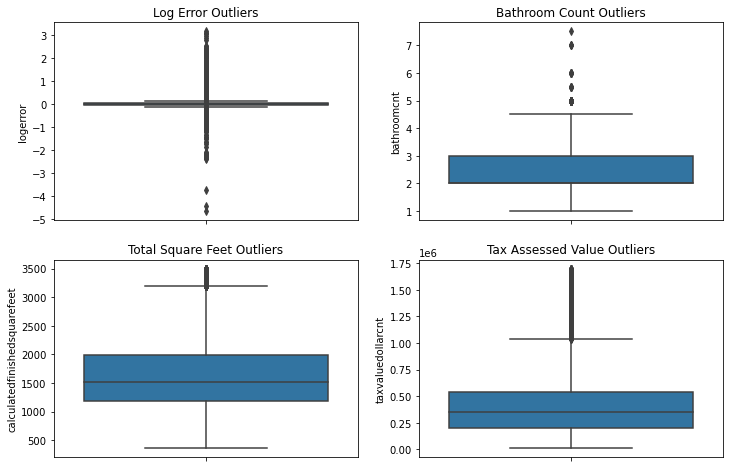

In [11]:
plt.figure(figsize = (12,8))
plt.subplot(221)
sns.boxplot(y = df.logerror)
plt.title('Log Error Outliers')

plt.subplot(222)
sns.boxplot(y = df.bathroomcnt)
plt.title('Bathroom Count Outliers')


plt.subplot(223)
sns.boxplot(y = df.calculatedfinishedsquarefeet)
plt.title('Total Square Feet Outliers')


plt.subplot(224)
sns.boxplot(y = df.taxvaluedollarcnt)
plt.title('Tax Assessed Value Outliers')

plt.show()

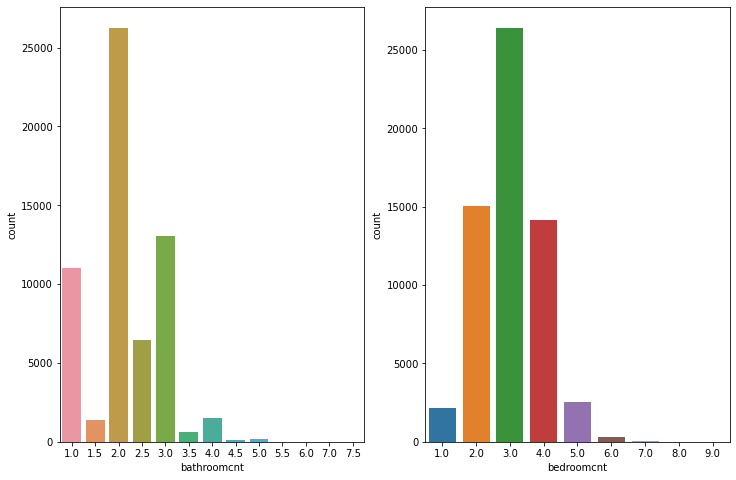

In [12]:
plt.figure(figsize = (12,8))
plt.subplot(121)
sns.countplot(data = df, x = 'bathroomcnt')

plt.subplot(122)
sns.countplot(data = df, x = 'bedroomcnt')








plt.show()

--------

<h3><u>Outlier Takeaways</u></h3>

----

 - The following columns were dealt with in regareds to outiers:
     - taxvaluedollarcnt
     - calculatedfinishedsquarefeet
     - taxrate
     - acres
     
     
After removing outliers, the data exploration will be able to yield more information into the strongest drivers of logerror

<h3><u>Data Dictionary</u></h3>



- Below is our most current data dictionary.



|   Feature      |  Data Type   | Description    |
| :------------- | :----------: | -----------: |
|  parcelid | float64  | Unique parcel identifier    |
| heatingorsystemtypeid    | float64| Identifier for heating type|
| airconditioningtypeid  | float64 | Identifier for ac type|
| bathroomcnt | float64 |number of bathrooms in property|
|  bedroomcnt    | float64  | number of bedrooms in property   |
| calculatedfinishedsquarefeet   | float64 | total livable square footage|
| fips    | object| Federal Information Processing Code (county code)|
| latitude | float64 | geographic coordinate that specifies the north–south position|
|  longitude  | float64   | geographic coordinate that specifies the east-west position |
| poolcnt    | float64 | has pool = 1, no pool = 0|
| roomcnt   | float64 | count of rooms in property|
| yearbuilt   | float64 | year home was built |
|  fireplaceflag  | int64   | Has fireplace = 1, no fireplace = 0     |
| taxvaluedollarcnt   | float64 | The most recent year property taxes were assessed|
| taxamount   | float64 | ad valorem tax on the value of a property.|
| logerror  | float64 | age of home as of today's date in years|
| transactiondate     | datetime64[ns] | date property was last sold|
| airconditioningdesc   | object | description of AC type|
| heatingorsystemdesc  | object| description of Heating type|
|age_of_home  | float64   | Current date - Year Built in years    |
|  age_bin  | float64 | year home was built|
|  baths_per_sqft | float64 | numbers of baths per sqft|
|  taxrate   | float64 | This is property tax / tax_assessed_value |
|  acres   | float64   | lot square footage / 43,560     |
|  acres_bin   | float64 | properties binned into groups by acreage amounts|
|  sqft_bin | float64 | properties binned into groups by square footage amounts|
|  bath_bed_ratio  | float64 | bathroomcnt/bedroomcnt|
|   la_county   | uint8  | property in LA = 1, not in LA = 0|
|  orange_county  | uint8  | property in Orange = 1, not in Orange = 0|
| ventura_county  | uint8 | property in Ventura = 1, not in ventura = 0|
















-----

<h3> Explore the Data </h3>

-----

In [15]:
df.describe()

,heatingorsystemtypeid,airconditioningtypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,taxvaluedollarcnt,...,taxrate,acres,acres_bin,sqft_bin,bath_bed_ratio,has_amenities,bath_amenity_house,la_county,orange_county,ventura_county
count,"60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00",...,"60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00","60,655.00"
mean,3.02,4.21,2.16,3.01,"1,639.32",33.99,-118.18,"8,066.93",1.73,"407,343.06",...,1.28,0.19,0.17,0.34,0.75,0.26,0.23,0.60,0.31,0.09
std,3.45,2.21,0.76,0.92,621.02,0.27,0.37,"5,193.03",2.94,"281,038.39",...,0.23,0.12,0.10,0.17,0.27,0.44,0.42,0.49,0.46,0.29
min,1.00,1.00,1.00,1.00,360.00,33.34,-119.48,236.00,0.00,"11,089.00",...,0.21,0.01,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00
25%,1.00,5.00,2.00,2.00,"1,184.00",33.79,-118.40,"5,665.00",0.00,"203,503.00",...,1.16,0.13,0.10,0.20,0.50,0.00,0.00,0.00,0.00,0.00
50%,2.00,5.00,2.00,3.00,"1,512.00",33.99,-118.14,"7,200.00",0.00,"354,379.00",...,1.23,0.17,0.20,0.40,0.67,0.00,0.00,1.00,0.00,0.00
75%,2.00,5.00,3.00,4.00,"1,987.00",34.17,-117.90,"8,134.00",4.00,"538,797.50",...,1.34,0.19,0.20,0.40,1.00,1.00,0.00,1.00,1.00,0.00
max,24.00,13.00,7.50,9.00,"3,499.00",34.75,-117.55,"36,805.00",12.00,"1,699,148.00",...,2.30,0.84,0.40,0.70,7.50,1.00,1.00,1.00,1.00,1.00


In [16]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, train_scaled, validate_scaled, test_scaled = split_seperate_scale(df)

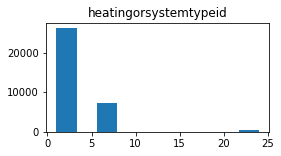

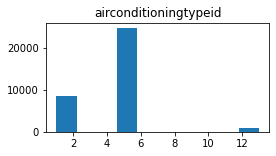

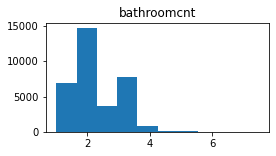

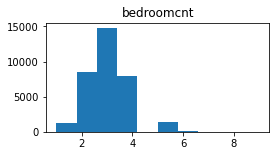

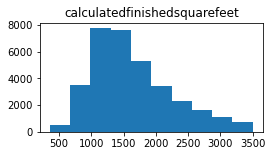

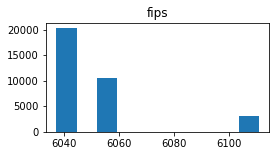

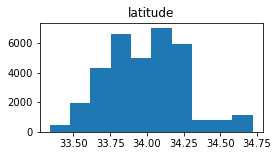

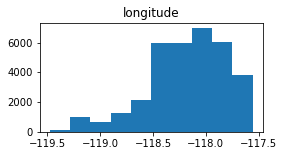

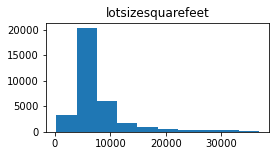

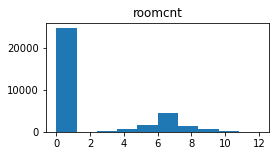

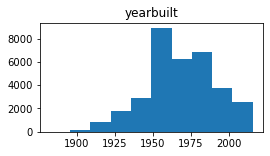

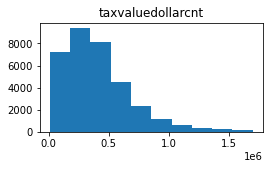

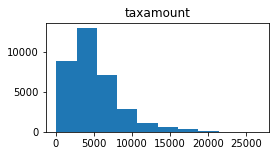

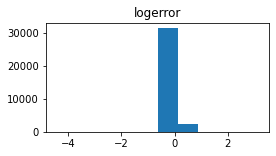

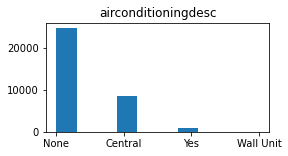

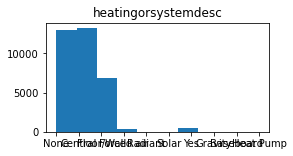

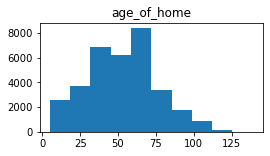

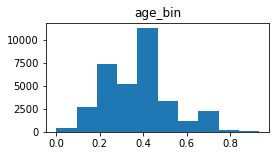

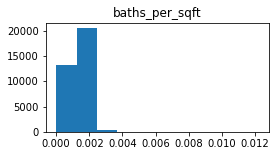

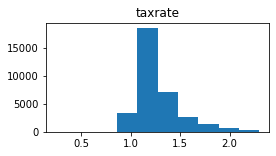

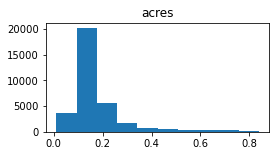

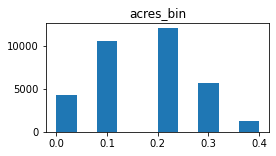

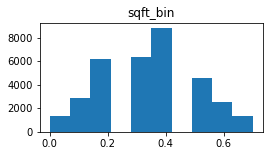

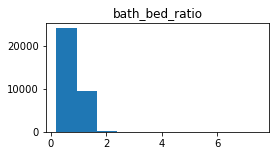

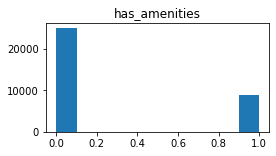

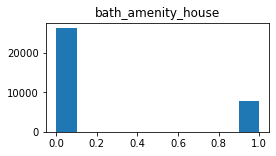

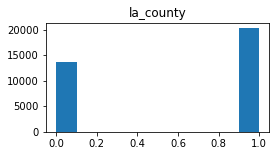

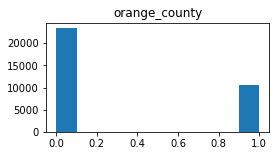

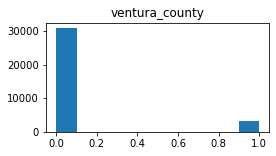

In [17]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

Quick Takeaways

- Our square footage is right skewed along with the tax value. 

Log Error Insights

[(-0.75, 0.75)]

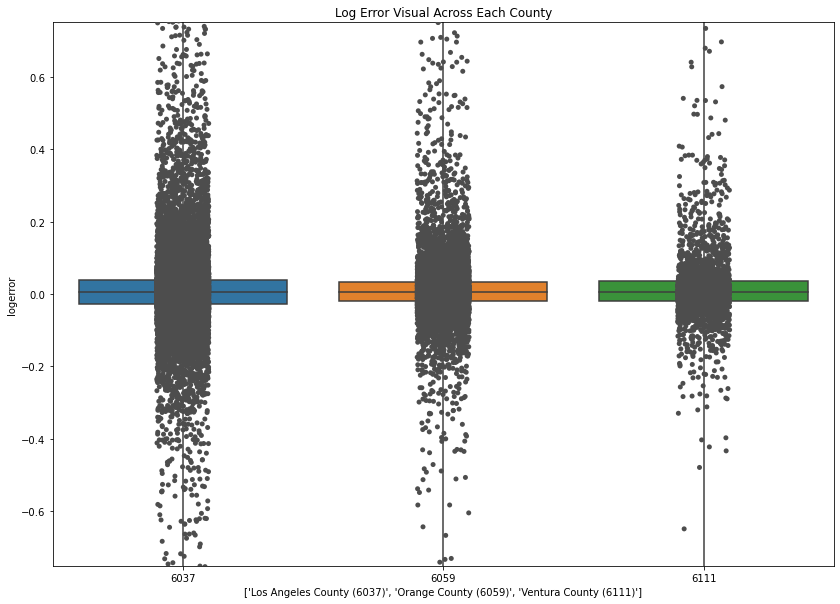

In [18]:

plt.figure(figsize=(14,10))



ax = sns.boxplot(x="fips", y="logerror", data=train,whis=np.inf )
ax = sns.stripplot(x="fips", y="logerror", data=train, color=".3")
ax.set_xlabel(['Los Angeles County (6037)', 'Orange County (6059)', 'Ventura County (6111)'])
plt.title('Log Error Visual Across Each County')

ax.set(ylim=(-.75, .75))

count              33,966.00
mean                    0.01
std                     0.16
min                    -4.45
25%                    -0.02
50%                     0.01
75%                     0.04
max                     3.18
Name: logerror, dtype: float64


<AxesSubplot:>

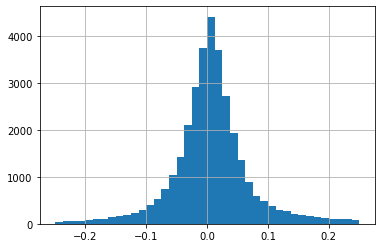

In [19]:
# Look at the distribution of the target variable (log-error)
print(train['logerror'].describe())
train.loc[abs(train['logerror']) < .25, 'logerror'].hist(bins=40)


-----
<h4>Instant Takeaway</h4>

- After taking outliers out of log error, Ventura County appears to have a higher percentage of properties near the mean of .1
- LA & Orange County appear to have a larger variance of log error among them.
- When log error is plotted as a histogram, it apperas normally distributed

-----


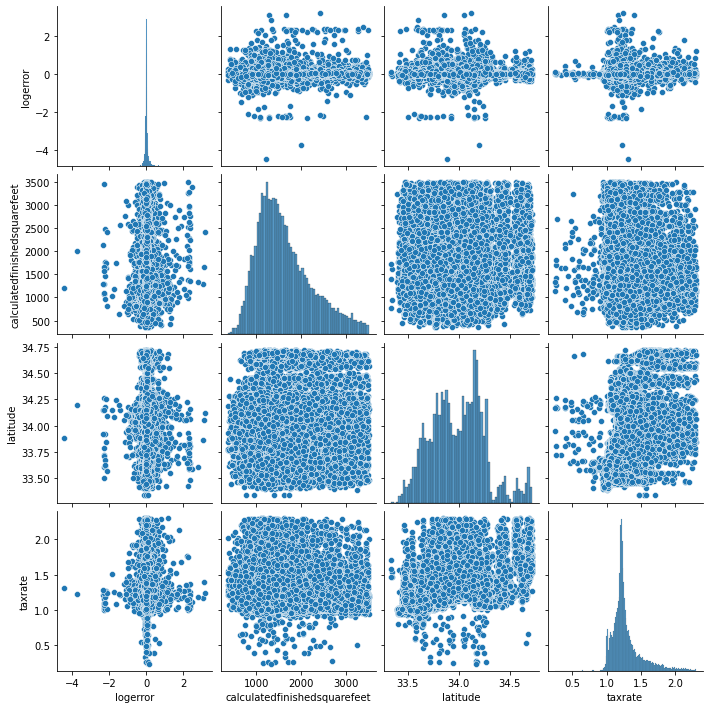

In [20]:
sns.pairplot(data=train[['logerror','calculatedfinishedsquarefeet','latitude',  'taxrate']], corner=False )

In [21]:
zillowdata = df[df.columns[1:]].corr()['logerror'][:]

zillowcorr= pd.DataFrame(data=zillowdata)

zillowcorr


,logerror
airconditioningtypeid,0.01
bathroomcnt,0.02
bedroomcnt,0.03
calculatedfinishedsquarefeet,0.03
latitude,-0.01
longitude,0.01
lotsizesquarefeet,0.01
roomcnt,0.02
taxvaluedollarcnt,-0.02
taxamount,-0.02



-----
<h4>Instant Takeaway</h4>

- After looking at a number of pair plots and the correlation data frame, there isn't any discernable correlation between log error and any of the features
- We will need to go into clustering to see if we can find a better way to combine features to help group these properties together.
-----


---
<h4>County By County Stats Test with Log Error</h4>

----

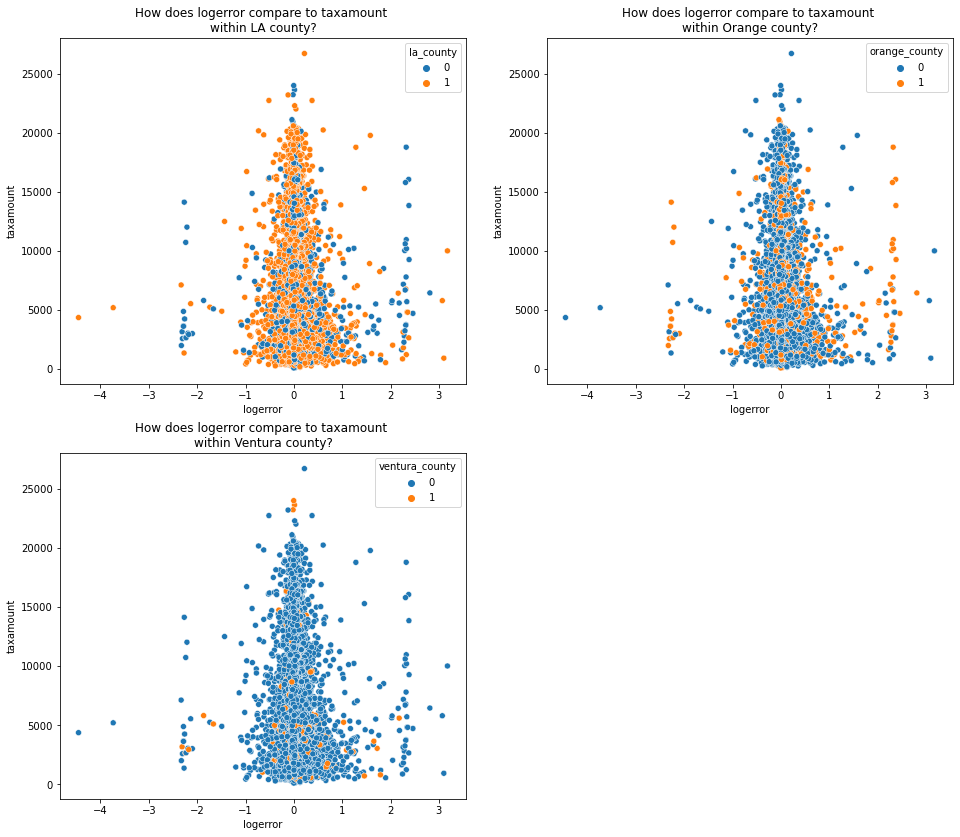

In [22]:
plt.figure(figsize = (16,14))
plt.subplot(221)
sns.scatterplot(x='logerror', y='taxamount',
               data=train, hue='la_county')
plt.title("How does logerror compare to taxamount \nwithin LA county?")

plt.subplot(222)
sns.scatterplot(x='logerror', y='taxamount',
               data=train, hue='orange_county')
plt.title("How does logerror compare to taxamount \nwithin Orange county?")

plt.subplot(223)
sns.scatterplot(x='logerror', y='taxamount',
               data=train, hue='ventura_county')
plt.title("How does logerror compare to taxamount \nwithin Ventura county?")
plt.show()

----

<h4>We used t-testing to examine if there was a difference in log error for properties in a county and those not in one.</h4>


<b> Main Takeaway</b>

- Only one county was able to reject the null hypothesis and that was LA. This may be in part due to it having a larger data set compared to the other two counties which means it may contain more outliers which can push it to have a logerror rate more affected by those extremes

-----

In [23]:
null = 'There is no difference in logerror rates between homes in LA and homes not in LA'

alt = 'There is a difference in logerror rates between homes in LA and homes not in LA'

alpha = .05

t, p = stats.ttest_ind(train[train.la_county == 0].logerror, 
                train[train.la_county == 1].logerror,
                equal_var=False
               )
print(t)
print(p)

if p < alpha:
    print(alt)
else:
    print(null)

2.160143897680223
0.03077020787825364
There is a difference in logerror rates between homes in LA and homes not in LA


In [24]:
null = 'There is no difference in logerror rates between homes in Orange and homes not in Orange'

alt = 'There is a difference in logerror rates between homes in Orange and homes not in Orange'

t, p = stats.ttest_ind(train[train.orange_county == 1].logerror, 
                train[train.orange_county == 0].logerror,
                equal_var=False
               )
print(t)
print(p)

if p < alpha:
    print(alt)
else:
    print(null)

1.816680129972661
0.06928264164944066
There is no difference in logerror rates between homes in Orange and homes not in Orange


In [25]:
null = 'There is no difference in logerror rates between homes in Ventura and homes not in Ventura'

alt = 'There is a difference in logerror rates between homes in Ventura and homes not in Ventura'

t, p = stats.ttest_ind(train[train.ventura_county == 0].logerror, 
                train[train.ventura_county == 1].logerror,
                equal_var=False
               )
print(t)
print(p)

if p < alpha:
    print(alt)
else:
    print(null)

-0.7271771865538053
0.46716154982113445
There is no difference in logerror rates between homes in Ventura and homes not in Ventura


---
<h4>Do homes that have amenities have different logerror rates than homes that do not have amenitites?</h4>

---

(-0.4, 0.4)

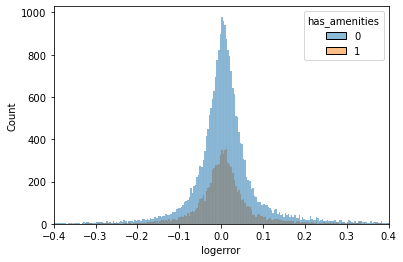

In [26]:
sns.histplot(data = train, x = 'logerror', hue = 'has_amenities')
plt.xlim(-.4, .4)


In [27]:
null = 'There is no difference in logerror rates between homes with amenities and homes that do not'

alt = 'There is a difference in logerror rates between homes in with amenities and homes that do not'

alpha = .05

x1 = train[train.has_amenities == 0].logerror
x2 = train[train.has_amenities != 0].logerror

xbar1 = x1.mean()
xbar2 = x2.mean()

n1 = x1.shape[0]
n2 = x2.shape[0]

s1 = x1.std()
s2 = x2.std()

degf = n1 + n2 - 2

s_p = sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
s_p

standard_error = se = sqrt(s1**2 / n1 + s2**2 / n2)

t = (xbar1 - xbar2) / (s_p * sqrt(1/n1 + 1/n2))

p = stats.t(degf).sf(t) * 2

print(t, p)

if p > alpha:
    print('We fail reject the null hypothesis that there is no difference in logerror rates between homes with amenities and homes that do not')
else: 
    print(alt)

1.5072066554180354 0.13176699552262477
We fail reject the null hypothesis that there is no difference in logerror rates between homes with amenities and homes that do not


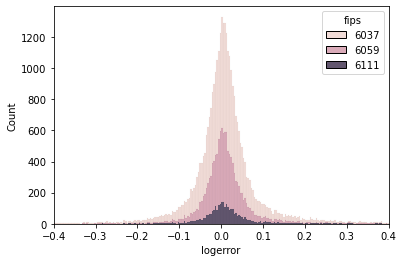

In [28]:
sns.histplot(data=train, x="logerror", hue = "fips", multiple="stack")
plt.xlim(-.4, .4)
plt.show()

The p-value is: 1.9991272042784917e-07 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = 0.03


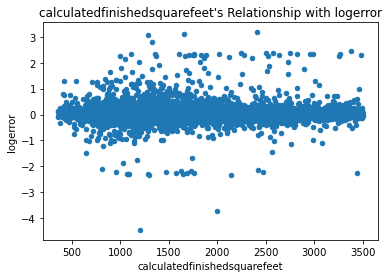

In [29]:
explore.correlation_exploration(train, 'calculatedfinishedsquarefeet', 'logerror')

-----

<h3> Clustering </h3>

-----

<h4>Longitude + Latitude</h4>

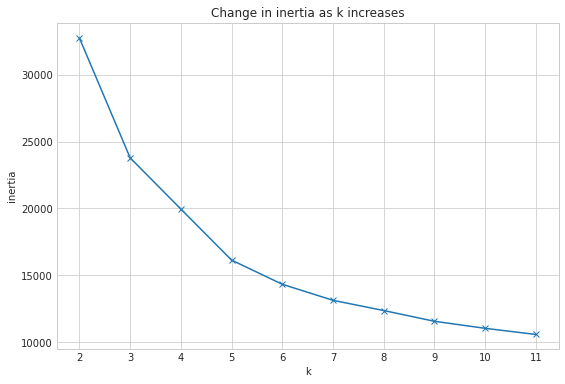

In [30]:
# assign variable we will use in our model

X = train_scaled[['longitude', 'latitude']]

#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

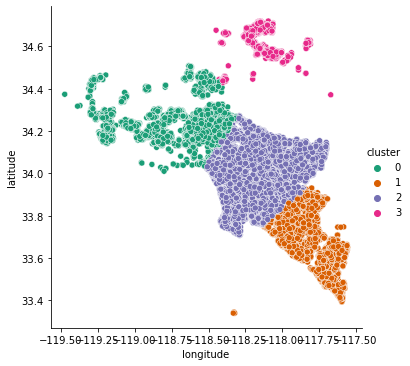

In [31]:
kmeans = KMeans(n_clusters=4, random_state=319)
kmeans.fit(X)
kmeans.predict(X)

train_scaled['cluster'] = kmeans.predict(X)

train['cluster'] = kmeans.predict(X)

## store the predictions as a column on your df

sns.relplot(data=train, x='longitude', y='latitude', hue='cluster', palette= 'Dark2')
plt.show()

In [32]:
H0 = 'There is no difference in the logerror between Cluster 0 and the general population'

H1 = 'There is a difference in the logerror between Cluster 0 and the general population'

alpha = .05

In [33]:
cluster0 = train[train.cluster == 0]

μ = train.logerror.mean()
xbar = cluster0.logerror.mean()
s = cluster0.logerror.std()
n = cluster0.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 0 and the general population')
else: 
    print(H1)

-0.03747179614379177 1.0298901439630033
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 0 and the general population


In [34]:
H0 = 'There is no difference in the logerror between Cluster 1 and the general population'

H1 = 'There is a difference in the logerror between Cluster 1 and the general population'

In [35]:
cluster1 = train[train.cluster == 1]

μ = train.logerror.mean()
xbar = cluster1.logerror.mean()
s = cluster1.logerror.std()
n = cluster1.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 1 and the general population')
else: 
    print(H1)

1.1882591139446446 0.23476079391203758
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 1 and the general population


In [36]:
H0 = 'There is no difference in the logerror between Cluster 2 and the general population'

H1 = 'There is a difference in the logerror between Cluster 2 and the general population'

In [37]:
cluster2 = train[train.cluster == 2]

μ = train.logerror.mean()
xbar = cluster1.logerror.mean()
s = cluster2.logerror.std()
n = cluster2.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 2 and the general population')
else: 
    print(H1)

1.6179349971714894 0.1056969336028265
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 2 and the general population


In [38]:
H0 = 'There is no difference in the logerror between Cluster 3 and the general population'

H1 = 'There is a difference in the logerror between Cluster 3 and the general population'

In [39]:
cluster3 = train[train.cluster == 3]

μ = train.logerror.mean()
xbar = cluster3.logerror.mean()
s = cluster3.logerror.std()
n = cluster3.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 3 and the general population')
else: 
    print(H1)

-1.1868716676102002 1.764544569774287
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 3 and the general population


----
<h4>Calculated Finish SQFT + Age + Latitude</h4>

----

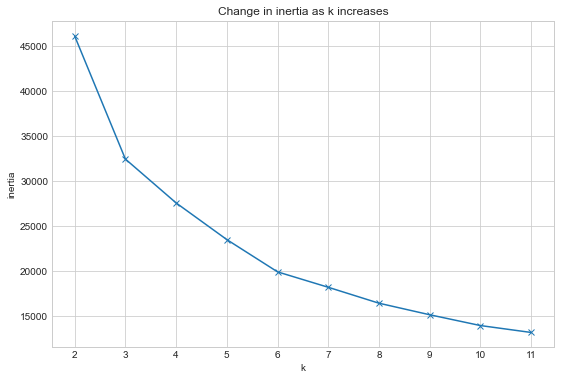

In [40]:
# assign variable we will use in our model

X = train_scaled[['calculatedfinishedsquarefeet', 'age_of_home', 'latitude']]

#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    plt.show()

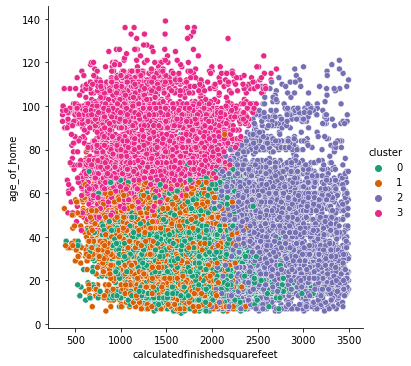

In [41]:
kmeans = KMeans(n_clusters=4, random_state=319)

## make the model, n_clusters being how many clusters you want in your model 

kmeans.fit(X)

## fit the model to the fields you want to use in your model

kmeans.predict(X)

## make your predictions

train_scaled['cluster'] = kmeans.predict(X)
train['cluster'] = kmeans.predict(X)

## store the predictions as a column on your df

sns.relplot(data=train, x='calculatedfinishedsquarefeet', y='age_of_home', hue='cluster', palette= 'Dark2')
plt.show()

In [42]:
H0 = 'There is no difference in the logerror between Cluster 0 and the general population'

H1 = 'There is a difference in the logerror between Cluster 0 and the general population'

alpha = .05

In [43]:
cluster0 = train[train.cluster == 0]

μ = train.logerror.mean()
xbar = cluster0.logerror.mean()
s = cluster0.logerror.std()
n = cluster0.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 0 and the general population')
else: 
    print(H1)

-0.9588541418859009 1.6623358094380525
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 0 and the general population


In [44]:
H0 = 'There is no difference in the logerror between Cluster 1 and the general population'

H1 = 'There is a difference in the logerror between Cluster 1 and the general population'



In [45]:
cluster1 = train[train.cluster == 1]

μ = train.logerror.mean()
xbar = cluster1.logerror.mean()
s = cluster1.logerror.std()
n = cluster1.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 1 and the general population')
else: 
    print(H1)

-0.5759431832660244 1.4353312073404325
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 1 and the general population


In [46]:
H0 = 'There is no difference in the logerror between Cluster 2 and the general population'

H1 = 'There is a difference in the logerror between Cluster 2 and the general population'



In [47]:
cluster2 = train[train.cluster == 2]

μ = train.logerror.mean()
xbar = cluster2.logerror.mean()
s = cluster2.logerror.std()
n = cluster2.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 2 and the general population')
else: 
    print(H1)

3.848242551534644 0.0001201965980944002
There is a difference in the logerror between Cluster 2 and the general population


In [48]:
H0 = 'There is no difference in the logerror between Cluster 3 and the general population'

H1 = 'There is a difference in the logerror between Cluster 3 and the general population'

In [49]:
cluster3 = train[train.cluster == 3]

μ = train.logerror.mean()
xbar = cluster3.logerror.mean()
s = cluster3.logerror.std()
n = cluster3.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 3 and the general population')
else: 
    print(H1)

-1.8826143591080526 1.9402234835581644
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 3 and the general population


----
<h4>Tax rate + Square Feet + Age + Latitude</h4>

----

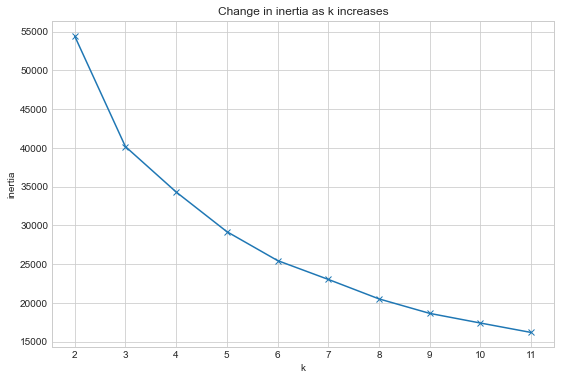

In [50]:
# assign variable we will use in our model

X = train_scaled[['latitude', 'calculatedfinishedsquarefeet', 'age_of_home', 'taxrate']]
X_validate = validate_scaled[['latitude', 'calculatedfinishedsquarefeet', 'age_of_home', 'taxrate']]
X_test = test_scaled[['latitude', 'calculatedfinishedsquarefeet', 'age_of_home', 'taxrate']]


#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    plt.show()

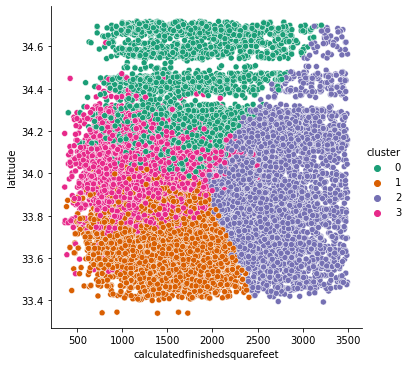

In [51]:
kmeans = KMeans(n_clusters=5, random_state=319)
## make the model, n_clusters being how many clusters you want in your model 

kmeans.fit(X)
## fit the model to the fields you want to use in your model

kmeans.predict(X)
kmeans.predict(X_validate)
kmeans.predict(X_test)
## make your predictions

train_scaled['modelcluster'] = kmeans.predict(X)
validate_scaled['modelcluster'] = kmeans.predict(X_validate)
test_scaled['modelcluster'] = kmeans.predict(X_test)
## store the predictions as a column on your df

train['modelcluster'] = kmeans.predict(X)
validate['modelcluster'] = kmeans.predict(X_validate)
test['modelcluster'] = kmeans.predict(X_test)

sns.relplot(data=train, x='calculatedfinishedsquarefeet', y='latitude', hue='cluster', palette= 'Dark2')
plt.show()

In [52]:
H0 = 'There is no difference in the logerror between Cluster 0 and the general population'

H1 = 'There is a difference in the logerror between Cluster 0 and the general population'

alpha = .05

In [53]:
modelcluster0 = train[train.modelcluster == 0]

μ = train.logerror.mean()
xbar = modelcluster0.logerror.mean()
s = modelcluster0.logerror.std()
n = modelcluster0.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 0 and the general population')
else: 
    print(H1)

-0.6979819385299377 1.5147897473538499
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 0 and the general population


In [54]:
H0 = 'There is no difference in the logerror between Cluster 1 and the general population'

H1 = 'There is a difference in the logerror between Cluster 1 and the general population'


In [55]:
modelcluster1 = train[train.modelcluster == 1]

μ = train.logerror.mean()
xbar = cluster1.logerror.mean()
s = modelcluster1.logerror.std()
n = modelcluster1.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 1 and the general population')
else: 
    print(H1)

-0.5240313122264529 1.399732117385375
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 1 and the general population


In [56]:
H0 = 'There is no difference in the logerror between Cluster 2 and the general population'

H1 = 'There is a difference in the logerror between Cluster 2 and the general population'

In [57]:
modelcluster2 = train[train.modelcluster == 2]

μ = train.logerror.mean()
xbar = modelcluster2.logerror.mean()
s = modelcluster2.logerror.std()
n = modelcluster2.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 2 and the general population')
else: 
    print(H1)

-1.0836791393101186 1.7214600106166535
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 2 and the general population


In [58]:
H0 = 'There is no difference in the logerror between Cluster 3 and the general population'

H1 = 'There is a difference in the logerror between Cluster 3 and the general population'

In [59]:
modelcluster3 = train[train.modelcluster == 3]

μ = train.logerror.mean()
xbar = modelcluster3.logerror.mean()
s = modelcluster3.logerror.std()
n = modelcluster3.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 3 and the general population')
else: 
    print(H1)

4.312520973325786 1.6403054916302112e-05
There is a difference in the logerror between Cluster 3 and the general population


In [60]:
H0 = 'There is no difference in the logerror between Cluster 4 and the general population'

H1 = 'There is a difference in the logerror between Cluster 4 and the general population'

In [61]:
modelcluster4 = train[train.modelcluster == 4]

μ = train.logerror.mean()
xbar = modelcluster4.logerror.mean()
s = modelcluster4.logerror.std()
n = modelcluster4.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 4 and the general population')
else: 
    print(H1)

-1.2133991828953452 1.774893152196816
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 4 and the general population


----
<h4>Tax rate + Square Feet + Age + Latitude + Amenities</h4>

----

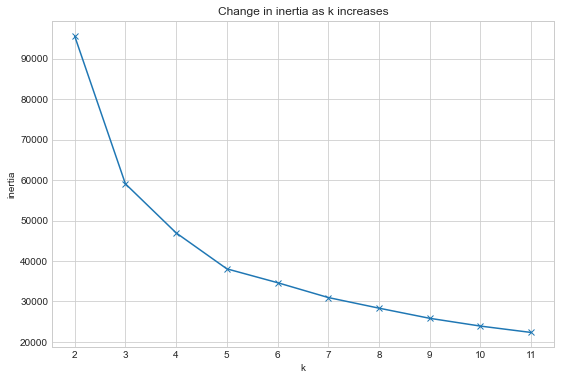

In [62]:
# assign variable we will use in our model

X = train_scaled[['latitude', 'calculatedfinishedsquarefeet', 'age_of_home', 'taxrate', 'has_amenities']]

#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    plt.show()

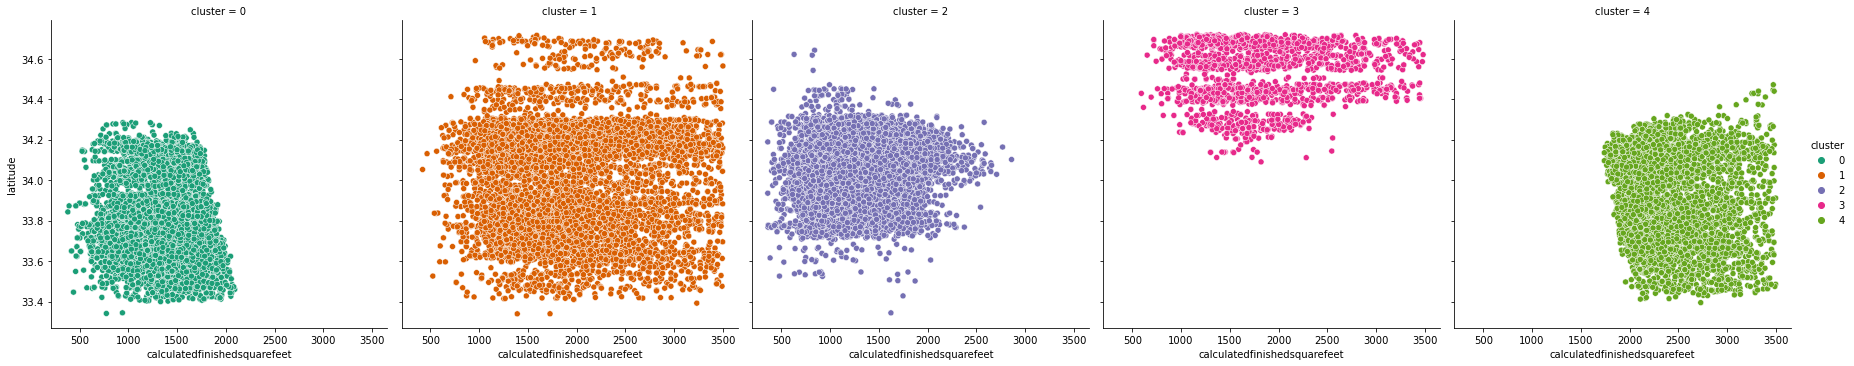

In [63]:
kmeans = KMeans(n_clusters=5, random_state=319)

## make the model, n_clusters being how many clusters you want in your model 

kmeans.fit(X)

## fit the model to the fields you want to use in your model

kmeans.predict(X)

## make your predictions

train_scaled['cluster'] = kmeans.predict(X)

train['cluster'] = kmeans.predict(X)

## store the predictions as a column on your df

sns.relplot(data=train, x='calculatedfinishedsquarefeet', y='latitude', hue='cluster', col = 'cluster', palette= 'Dark2')
plt.show()

In [64]:
H0 = 'There is no difference in the logerror between Cluster 0 and the general population'

H1 = 'There is a difference in the logerror between Cluster 0 and the general population'

alpha = .05

In [65]:
cluster0 = train[train.cluster == 0]

μ = train.logerror.mean()
xbar = cluster0.logerror.mean()
s = cluster0.logerror.std()
n = cluster0.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 0 and the general population')
else: 
    print(H1)

-1.6990277310426583 1.9106426055651002
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 0 and the general population


In [66]:
H0 = 'There is no difference in the logerror between Cluster 1 and the general population'

H1 = 'There is a difference in the logerror between Cluster 1 and the general population'

In [67]:
cluster1 = train[train.cluster == 1]

μ = train.logerror.mean()
xbar = cluster1.logerror.mean()
s = cluster1.logerror.std()
n = cluster1.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 1 and the general population')
else: 
    print(H1)

-1.3521426159766767 1.8236361343813368
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 1 and the general population


In [68]:
H0 = 'There is no difference in the logerror between Cluster 2 and the general population'

H1 = 'There is a difference in the logerror between Cluster 2 and the general population'

In [69]:
cluster2 = train[train.cluster == 2]

μ = train.logerror.mean()
xbar = cluster2.logerror.mean()
s = cluster2.logerror.std()
n = cluster2.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 2 and the general population')
else: 
    print(H1)

-0.16783811227319892 1.1332864027074903
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 2 and the general population


In [70]:
H0 = 'There is no difference in the logerror between Cluster 3 and the general population'

H1 = 'There is a difference in the logerror between Cluster 3 and the general population'

In [71]:
cluster3 = train[train.cluster == 3]

μ = train.logerror.mean()
xbar = cluster3.logerror.mean()
s = cluster3.logerror.std()
n = cluster3.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 3 and the general population')
else: 
    print(H1)

0.5179802585356174 0.6045236576521147
We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 3 and the general population


In [72]:
H0 = 'There is no difference in the logerror between Cluster 4 and the general population'

H1 = 'There is a difference in the logerror between Cluster 4 and the general population'

In [73]:
cluster4 = train[train.cluster == 4]

μ = train.logerror.mean()
xbar = cluster4.logerror.mean()
s = cluster4.logerror.std()
n = cluster4.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))

p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test

print(t, p)

if p > alpha:
    print('We fail to reject the null hypothesis that there is no difference in the logerror between Cluster 4 and the general population')
else: 
    print(H1)

3.338612751210014 0.0008493840574415334
There is a difference in the logerror between Cluster 4 and the general population


-----

<h3> Model the Data </h3>

-----

In [74]:
dummy_df = pd.get_dummies(train['modelcluster'])

dummy_df.columns = ['modelcluster0', 'modelcluster1', 'modelcluster2', 'modelcluster3', 'modelcluster4']


In [75]:
train = pd.concat([train, dummy_df], axis=1)

In [76]:
dummy_df = pd.get_dummies(validate['modelcluster'])

dummy_df.columns = ['modelcluster0', 'modelcluster1', 'modelcluster2', 'modelcluster3', 'modelcluster4']

validate = pd.concat([validate, dummy_df], axis=1)

In [77]:
dummy_df = pd.get_dummies(test['modelcluster'])

dummy_df.columns = ['modelcluster0', 'modelcluster1', 'modelcluster2', 'modelcluster3', 'modelcluster4']

test = pd.concat([test, dummy_df], axis=1)

In [78]:
X_train, y_train, X_validate, y_validate, X_test, y_test = seperate_y(train, validate, test)

In [79]:
X_train.drop(['cluster'], axis=1, inplace=True)

In [80]:
train_scaled, validate_scaled, test_scaled = scale_data(X_train, X_validate, X_test)

In [81]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [82]:
# 1. Predict logerror_mean
logerror_mean = y_train['logerror'].mean()
y_train['logerror_mean'] = logerror_mean
y_validate['logerror_mean'] = logerror_mean

In [83]:
# 2. compute logerror_median
logerror_median = y_train['logerror'].median()
y_train['logerror_median'] = logerror_median
y_validate['logerror_median'] = logerror_median

In [84]:
# 3. RMSE of logerror_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_mean)**(1/2)

In [85]:
# 4. RMSE of logerror_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_median)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

RMSE using Mean
Train/In-Sample:  0.16013310952440438 
Validate/Out-of-Sample:  0.1604117448479204


------
## LinearRegression (OLS)
-------

In [89]:
features = ['latitude', 'calculatedfinishedsquarefeet', 'age_of_home', 'taxrate', 'modelcluster3']

In [90]:
# create the model object
lm = LinearRegression(normalize=True)

In [91]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(train_scaled[features], y_train.logerror)

LinearRegression(normalize=True)

In [122]:
# predict train
y_train['logerror_pred_lm'] = lm.predict(train_scaled[features])

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(validate_scaled[features])

In [123]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15977825638818044 
Validation/Out-of-Sample:  0.15990220639419334


---------
## LassoLars
------

In [144]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(train_scaled[features], y_train.logerror)



LassoLars(alpha=1)

In [145]:
# predict train
y_train['logerror_pred_lars'] = lars.predict(train_scaled[features])

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(validate_scaled[features])

In [146]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.15988791741747663 
Validation/Out-of-Sample:  0.16005107668563168


----
## TweedieRegressor (GLM)
----

In [126]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

In [127]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(train_scaled[features], y_train.logerror)

TweedieRegressor(alpha=0, power=0)

In [128]:
# predict train
y_train['logerror_pred_glm'] = glm.predict(train_scaled[features])

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(validate_scaled[features])

In [129]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.15977836773647175 
Validation/Out-of-Sample:  0.15990219566508712


----
## Polynomial Regression
----

<h5>Polynomial Features</h5>

----

In [130]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

In [131]:
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(train_scaled[features])

In [132]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(validate_scaled[features])
X_test_degree2 = pf.transform(test_scaled[features])

----
<h5>Linear Regression</h5>

---

In [133]:
# create the model object
lm2 = LinearRegression(normalize=True)

In [134]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

LinearRegression(normalize=True)

In [135]:
# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

In [136]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)


print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.15970127792920355 
Validation/Out-of-Sample:  0.15987553690285308


-----
## Evaluate

----

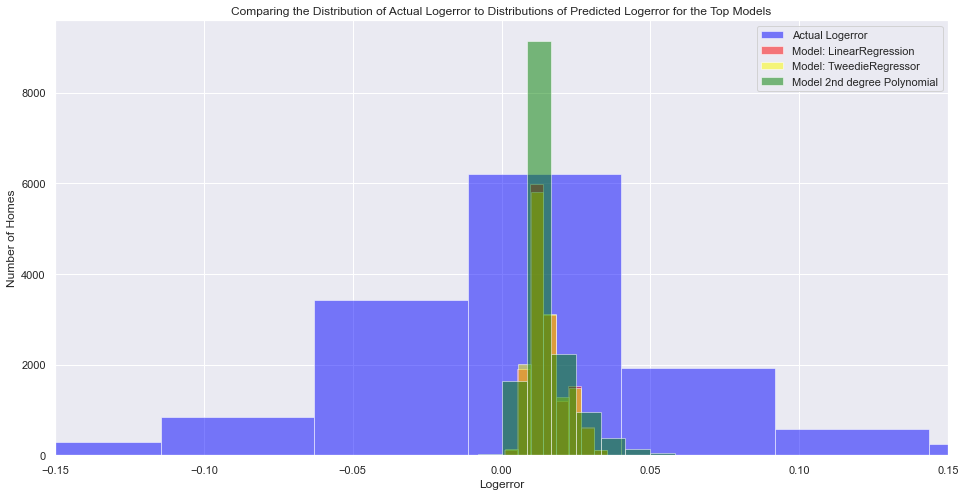

In [150]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.logerror, color='blue', alpha=.5, label="Actual Logerror", bins=150)
plt.hist(y_validate.logerror_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.logerror_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.logerror_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Logerror")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Logerror to Distributions of Predicted Logerror for the Top Models")
plt.legend()
plt.xlim(-.15, .15)
plt.show()

----

<h3>Distribution Takeaways</h3>

- Our final model seems to have predicted all values within a very small range

- this may be due to outliers 



---

Text(0.5, 1.0, 'Model: Polynomial Regresser')

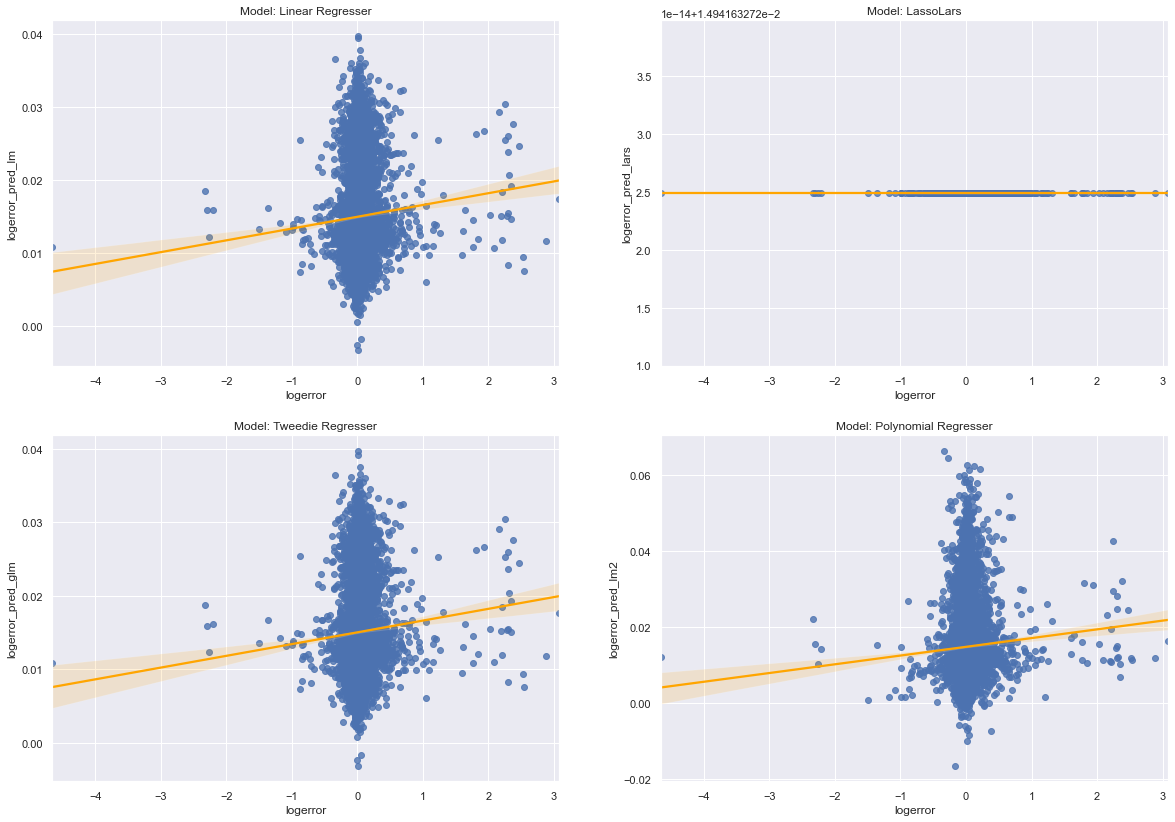

In [147]:
plt.subplots(2, 2, figsize=(20, 14), sharey=True)
sns.set(style="darkgrid")
plt.subplot(2,2,1)
sns.regplot(x= y_validate.logerror, y= y_validate.logerror_pred_lm, line_kws={"color": "orange"})
plt.title("Model: Linear Regresser")
plt.subplot(2,2,2)
sns.regplot(x= y_validate.logerror, y= y_validate.logerror_pred_lars, line_kws={"color": "orange"})
plt.title("Model: LassoLars")
plt.subplot(2,2,3)
sns.regplot(x= y_validate.logerror, y= y_validate.logerror_pred_glm, line_kws={"color": "orange"})
plt.title("Model: Tweedie Regresser")
plt.subplot(2,2,4)
sns.regplot(x= y_validate.logerror, y= y_validate.logerror_pred_lm2, line_kws={"color": "orange"}) 
plt.title("Model: Polynomial Regresser")

----

<h3>Subplot Takeaways</h3>

- LassoLars seems to have just predicted the mean

- The other models all look similar

- Most actual values centered around 0
- Widest range of predicted values also near 0

----

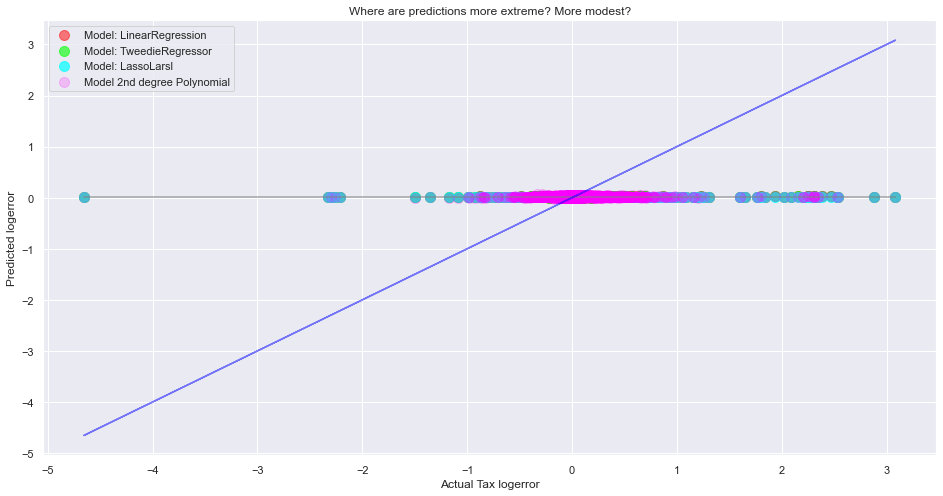

In [154]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_mean, alpha=.5, color="gray", label='_nolegend_')

plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='_nolegend_')

plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm, 
            alpha=.6, color="lime", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars, 
            alpha=.7, color="cyan", s=100, label="Model: LassoLarsl")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2, 
            alpha=.2, color="magenta", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax logerror")
plt.ylabel("Predicted logerror")
plt.title("Where are predictions more extreme? More modest?")


plt.show()

-----

<h3>Graph Takeaways</h3>

- the lower the actual logerror, the more our model prediected it was higher than it actually was

- the higher the actual logerror, the more our model predicted it was lower than it actually was 

- the only play our model's prediction seems to be correct is where the actual logerror was 0 or close to 0

---

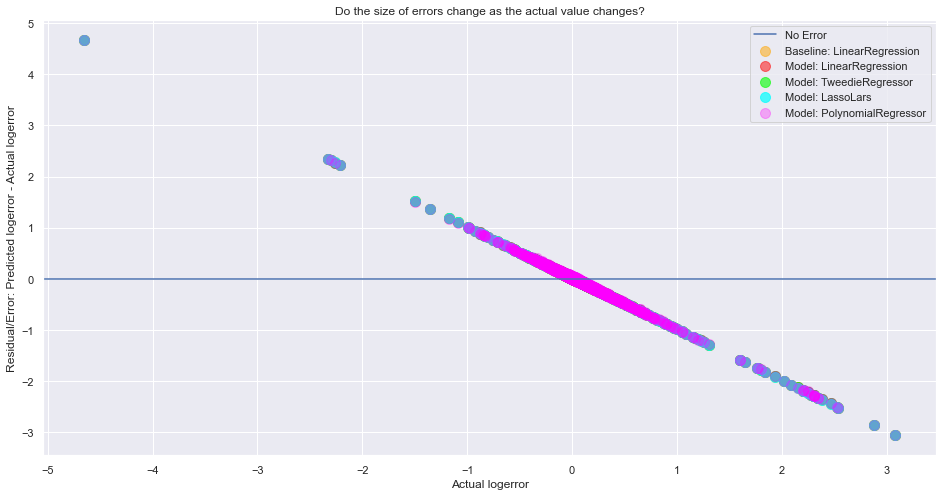

In [155]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")

plt.scatter(y_validate.logerror, y_validate.logerror_mean - y_validate.logerror , 
            alpha=.5, color="orange", s=100, label="Baseline: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm - y_validate.logerror , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm - y_validate.logerror, 
            alpha=.6, color="lime", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars - y_validate.logerror , 
            alpha=.7, color="cyan", s=100, label="Model: LassoLars")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2 - y_validate.logerror , 
            alpha=.3, color="magenta", s=100, label="Model: PolynomialRegressor")
plt.legend()
plt.xlabel("Actual logerror")
plt.ylabel("Residual/Error: Predicted logerror - Actual logerror")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

-----

## Let's Test the Data

----

In [157]:
# predict on test
y_test['logerror_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Regressor using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Polynomial Regressor using LinearRegression
Out-of-Sample Performance:  0.15273409968316787


----

<h4>Takeaways</h4>
- Our Polynomial Model performed better on the out of sample data than our validate or train.

-----
## R^2

----

In [187]:
r2train = r2_score(y_train.logerror, y_train.logerror_pred_lm2)
r2validate = r2_score(y_validate.logerror, y_validate.logerror_pred_lm2)
r2test = r2_score(y_test.logerror, y_test.logerror_pred_lm2)


print(f'The r^2 score for train came out to {r2train:.6f}')
print(f'The r^2 score for validate is {r2validate:.6f}')
print(f'The r^2 score for test is {r2test:.6f}')

The r^2 score for train came out to 0.002333
The r^2 score for validate is 0.002021
The r^2 score for test is 0.000617


-----

<h4>Takeaways</h4>

- our model does not appear to explain very much variance at all and appears to be a bad fit although it performs the best of the 4

----



<h3>Conclusions & Thoughts Moving Forward</h3>

-----

The polynomial regressor using 2 degrees was the most effective model in predicitng log error. 
- It peformed best on the out-of-sample and validate
- The log error was essentially normally distributed although it had exteme positive and negative outliers.

Moving forward, it appears that since there is little to no correlation between the log error and features within the data set, there must be outside factors that are contributing to either an overvalued or undervalued zestimate 

These outside factors would need to be investigated more and we would want to find a way to bring them into our modeling to reduce log error.

